# Notebook Memory Networks - Question Answering

### The dataset can be downloaded - https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz

In [95]:
# import the necessary packages

from keras.layers import Input
from __future__ import division, print_function
from keras.layers.core import Dense, Activation, Dropout, Permute
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add,dot, concatenate
import os

import collections
import nltk
import numpy as np
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

### Read the files to create train and test data

In [101]:
TRAIN_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/nbs/datasets/FB_BABL_Ques_Answering/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt"
TEST_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/nbs/datasets/FB_BABL_Ques_Answering/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt"

def parseFile(infile):
    stories = []
    ques = []
    answers = []
    story_text = []
    # This parses each line and creates the stories, questions and answers tuple
    for line in open(infile, 'rb'):
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            ques.append(question)
            answers.append(answer)
            stories.append(story_text)
            story_text = []
        else:
            story_text.append(text)
#     print(ques)
    return stories, ques, answers
    
train_data = parseFile(TRAIN_FILE)
test_data = parseFile(TEST_FILE)

In [103]:
# swap the subscript for the train_data and test_data to 0 or 1 or 2 to get the Stories, Questions or Answers

print(len(train_data[0]))
print(" ")
print(len(test_data[0]))

print(train_data[0])

1000
 
1000
[['Mary moved to the bathroom.', 'John went to the hallway.'], ['Daniel went back to the hallway.', 'Sandra moved to the garden.'], ['John moved to the office.', 'Sandra journeyed to the bathroom.'], ['Mary moved to the hallway.', 'Daniel travelled to the office.'], ['John went back to the garden.', 'John moved to the bedroom.'], ['Sandra travelled to the office.', 'Sandra went to the bathroom.'], ['Mary went to the bedroom.', 'Daniel moved to the hallway.'], ['John went to the garden.', 'John travelled to the office.'], ['Daniel journeyed to the bedroom.', 'Daniel travelled to the hallway.'], ['John went to the bedroom.', 'John travelled to the office.'], ['Mary went to the bedroom.', 'John journeyed to the bathroom.'], ['Sandra journeyed to the hallway.', 'John journeyed to the garden.'], ['John journeyed to the bathroom.', 'Sandra journeyed to the garden.'], ['Sandra went back to the bedroom.', 'Daniel travelled to the bathroom.'], ['John went to the office.', 'Mary move

### Build Vocab from train and test data

In [106]:
def buildVocab(train_data, test_data):
    # this loop runs through all the sentences , questions and answers and creates a counter with the counts for 
    # unique words and their counts.
    # this method returns the word2index and index2word mappings 
    word_counts = collections.Counter()
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            for sent in story:
                for word in nltk.word_tokenize(sent):
                    word_counts[word] += 1
        for ques in questions:
            for word in nltk.word_tokenize(ques):
                word_counts[word] += 1
        for ans in answers:
            for word in nltk.word_tokenize(ans):
                word_counts[word] += 1
    print(len(word_counts))
    print(" ")
    print(word_counts)
    
    # now create the word2index and index2word maps
    i=0
    word2index = {w:i+1 for i,(w, _) in enumerate(word_counts.most_common())}
    word2index[0] = "PAD"
#     print(" ")
#     print(len(word2index))
#     print(word2index)
    
    index2word = {v:k for k,v in word2index.items()}
#     print(" ")
#     print(len(index2word))
#     print(index2word)
    return word2index, index2word

word2index, index2word = buildVocab(train_data, test_data)
print(" ")
print(word2index)
print(" ")
print(index2word)

vocab_size = len(word2index)
print(vocab_size)        

21
 
Counter({'to': 4000, '.': 4000, 'the': 4000, 'Where': 2000, '?': 2000, 'is': 2000, 'went': 1604, 'Sandra': 1562, 'Daniel': 1508, 'John': 1507, 'Mary': 1423, 'garden': 1040, 'office': 1019, 'kitchen': 1010, 'bedroom': 984, 'hallway': 981, 'bathroom': 966, 'travelled': 827, 'journeyed': 793, 'moved': 776, 'back': 773})
 
{0: 'PAD', 'John': 10, 'to': 1, 'journeyed': 19, '?': 5, 'travelled': 18, 'bedroom': 15, 'Sandra': 8, 'garden': 12, 'hallway': 16, 'Daniel': 9, 'office': 13, 'the': 3, 'is': 6, 'went': 7, 'back': 21, 'kitchen': 14, '.': 2, 'moved': 20, 'bathroom': 17, 'Mary': 11, 'Where': 4}
 
{1: 'to', 2: '.', 3: 'the', 4: 'Where', 'PAD': 0, 6: 'is', 7: 'went', 8: 'Sandra', 9: 'Daniel', 10: 'John', 11: 'Mary', 12: 'garden', 13: 'office', 14: 'kitchen', 15: 'bedroom', 16: 'hallway', 17: 'bathroom', 18: 'travelled', 19: 'journeyed', 20: 'moved', 21: 'back', 5: '?'}
22


### Get Maximum Lengths for the story and Question

In [115]:
# this function finds the maximum length of a sentence (number of words in a sentence or questions)
def getMaXLength(train_data, test_data):
    s_maxlength =0
    q_maxlength=0
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            story_len = 0
            for sen in story:
                story_len += len(nltk.word_tokenize(sen))
            if story_len > s_maxlength:
                    s_maxlength = story_len
        for ques in questions:
            ques_length = len(nltk.word_tokenize(ques))
            if ques_length > q_maxlength:
                q_maxlength = ques_length    
    return s_maxlength, q_maxlength

story_maxlength, ques_maxlength = getMaXLength(train_data, test_data)
print(story_maxlength," ", ques_maxlength)

14   4


### Vectorize the Inputs and Pad the sequences

In [116]:
# Vectorize the inputs by padding the data to the same sizes.
def vectorize(data, word2index, story_maxlength, ques_maxlength):
    Xs, Xq, Y =[], [], []
    k=0
    stories, questions, answers = data
    
#     print(stories)
#     print(" ")
#     print(questions)
#     print(" ")
#     print(answers)
#     print(" ")
    
    for story, ques, ans in zip(stories, questions, answers):
        
        # loop through each of the sentences, questions and snwers and append them to the list
        # their indexes
        xs = [[word2index[w] for w in nltk.word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2index[w] for w in nltk.word_tokenize(ques)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2index[ans])
#         Y = np_utils.to_categorical(Y_indexes)
    # pad the sequences for sentences and questions and change answers to categorical values    
    return pad_sequences(Xs, story_maxlength), pad_sequences(Xq, ques_maxlength), np_utils.to_categorical(Y, num_classes=len(word2index))
    
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2index, story_maxlength, ques_maxlength)
Xstest, Xqtest, Ytest = vectorize(test_data, word2index, story_maxlength, ques_maxlength)

In [117]:
print(Xstrain.shape)
print(Xqtrain.shape)
print(Ytrain.shape)

print(" ")

print(Xstest.shape)
print(Xqtest.shape)
print(Ytest.shape)

print(" ")
print(Xstrain[1])

print(" ")
print(Ytrain[0])

(1000, 14)
(1000, 4)
(1000, 22)
 
(1000, 14)
(1000, 4)
(1000, 22)
 
[ 0  9  7 21  1  3 16  2  8 20  1  3 12  2]
 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.]


### Define the Model Architecture

In [118]:
# check the complex model architecture and define the architecture
# the detailed architecture can be found from the paper - memory networks

EMBEDDING_SIZE = 64
LSTM_NEURONS = 32
DROPOUT_RATE = 0.3
BATCH_SIZE = 32
NUM_EPOCHS = 50

# define the inputs
story_input = Input(shape=(story_maxlength,))
ques_input = Input(shape=(ques_maxlength,))

# define the Embeddings for the questions and the stories
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=story_maxlength) (story_input)
story_encoder = Dropout(DROPOUT_RATE)(story_encoder)

ques_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=ques_maxlength) (ques_input)
ques_encoder = Dropout(DROPOUT_RATE)(ques_encoder)

print("Ques Encoder - ",ques_encoder.shape)
print("Story Encoder - ", story_encoder.shape)

# use the dot operator
match = dot([story_encoder, ques_encoder], axes=[2,2])
print("Match - ",match.shape)

# define the second embedding of the story vector
story_encoder_2 = Embedding(input_dim=vocab_size, output_dim=ques_maxlength, input_length=story_maxlength)(story_input)
story_encoder_2 = Dropout(DROPOUT_RATE)(story_encoder_2)
print("Story Encoder 2 - ",story_encoder_2.shape)

# create the response tensor
response = add([ match, story_encoder_2])
print("Response shape - ", response.shape)
response = Permute((2,1))(response)
print("Response Shape after Permute - ",response.shape)
answer = concatenate([response, ques_encoder,], axis=-1)
print("Concatenate - ",answer.shape)
answer = LSTM(LSTM_NEURONS) (answer)
answer = Dropout(DROPOUT_RATE)(answer)
answer = Dense(vocab_size)(answer)
output = Activation('softmax')(answer)
print("Output Shape - ",output.shape)

model = Model(inputs=[story_input, ques_input], outputs=output)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])


Ques Encoder -  (?, 4, 64)
Story Encoder -  (?, 14, 64)
Match -  (?, 14, 4)
Story Encoder 2 -  (?, 14, 4)
Response shape -  (?, 14, 4)
Response Shape after Permute -  (?, 4, 14)
Concatenate -  (?, 4, 78)
Output Shape -  (?, 22)


### Fit the Model and Plot the Graphs

In [119]:
# fitting the model and evaluatig the Graph plots and the output on the test data
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=([Xstest,Xqtest], [Ytest]))

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 1s - loss: 2.6922 - acc: 0.1510 - val_loss: 2.0649 - val_acc: 0.1870
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 1.9820 - acc: 0.1830 - val_loss: 1.8500 - val_acc: 0.1870
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 1.9079 - acc: 0.1730 - val_loss: 1.8185 - val_acc: 0.1800
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 1.8541 - acc: 0.1950 - val_loss: 1.7913 - val_acc: 0.1680
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 1.8388 - acc: 0.1970 - val_loss: 1.7642 - val_acc: 0.2810
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 1.7986 - acc: 0.2220 - val_loss: 1.7333 - val_acc: 0.2720
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 1.7383 - acc: 0.2280 - val_loss: 1.6881 - val_acc: 0.2680
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 1.6976 - a

### Plot the validation and the train losses and accuracies

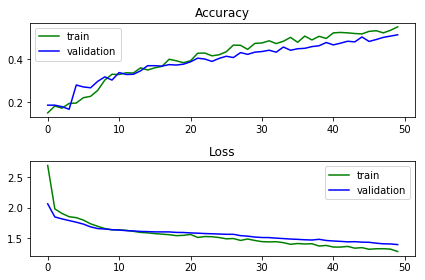

In [120]:
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['acc'], color='g', label='train')
plt.plot(history.history['val_acc'], color='b', label='validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], color='g', label='train')
plt.plot(history.history['val_loss'], color='b', label='validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Print some of the predicted sample values from the trained network

In [121]:
y_test = np.argmax(Ytest, axis=1)
Y_test_ = model.predict([Xstest, Xqtest])
y_test_ = np.argmax(Y_test_, axis=1)

print(y_test.shape)
print(y_test_.shape)

NUM_SAMPLES = 20

for i in range(NUM_SAMPLES):
#     print(Xstest[i])
    story = " ".join([index2word[x] for x in Xstest[i].tolist() if x!=0])
    ques = " ".join([index2word[x] for x in Xqtest[i].tolist()])
    ans = index2word[y_test[i]]
    pred = index2word[y_test_[i]]
    print(story, " ", ques, " ", ans, " ", pred)

(1000,)
(1000,)
John travelled to the hallway . Mary journeyed to the bathroom .   Where is John ?   hallway   bathroom
Daniel went back to the bathroom . John moved to the bedroom .   Where is Mary ?   bathroom   bedroom
John went to the hallway . Sandra journeyed to the kitchen .   Where is Sandra ?   kitchen   kitchen
Sandra travelled to the hallway . John went to the garden .   Where is Sandra ?   hallway   garden
Sandra went back to the bathroom . Sandra moved to the kitchen .   Where is Sandra ?   kitchen   kitchen
Sandra travelled to the kitchen . Sandra travelled to the hallway .   Where is Sandra ?   hallway   hallway
Mary went to the bathroom . Sandra moved to the garden .   Where is Sandra ?   garden   garden
Sandra travelled to the office . Daniel journeyed to the hallway .   Where is Daniel ?   hallway   office
Daniel journeyed to the office . John moved to the hallway .   Where is Sandra ?   office   hallway
John travelled to the bathroom . John journeyed to the office . 